In [4]:
#Import libraries
#!conda install -c conda-forge folium=0.5.0 --yes 
#!conda install -c conda-forge geopy --yes 

In [5]:
pip install requests


The following command must be run outside of the IPython shell:

    $ pip install requests

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [6]:
pip install lxml


The following command must be run outside of the IPython shell:

    $ pip install lxml

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [7]:
#notebook variables    
import lxml.html as lh
import pandas as pd
import requests  
import folium # map rendering library
import numpy as np 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Hidden cell

In [8]:
# The code was removed by Watson Studio for sharing.

In [ ]:
#scrape site urls for roseville california and chandler arizona our from and to cities
url_azcities = 'https://www.distantias.com/towns-radius-chandler-arizona-united_states.htm'
url_cacities = 'https://www.distantias.com/towns-radius-roseville-california-united_states.htm'

In [9]:
#get roseville ca, & surrounding cities from scrape site and place in dataframe
page = requests.get(url_cacities)
tree =lh.fromstring(page.content)
tr_rows = tree.xpath('//tr')

#table headings
col=[]
i=0

for t in tr_rows[1]:
    i+=1
    name=t.text_content()
    print  (i,name)
    col.append((name.rstrip('\n'),[]))

#get table row values    
for j in range(1,len(tr_rows)):
    T=tr_rows[j]
    if len(T)!=7:
         break
        #i is the index of our column
    i=0
     #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Append the data to the empty list of the i'th column
        col[i][1].append(data.rstrip('\n'))
        #Increment i for the next column
        i+=1    

[len(C) for (title,C) in col]   
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()

1 Town
2 mi.
3 km.
4 Area
5 Country
6 Pop
7 Dir


,Town,mi.,km.,Area,Country,Pop,Dir
0,Town,mi.,km.,Area,Country,Pop,Dir
1,Orangevale,4.50,7.24,California,United States,26135,SE
2,Citrus Heights,4.63,7.45,California,United States,84330,SW
3,Granite Bay,5.07,8.16,California,United States,19407,NE
4,Rocklin,5.34,8.59,California,United States,58324,NW


In [10]:
#determine top 5 by closest to Roseville a min of 10miles
df.drop(df.index[0], inplace=True)
df['mi.'] =  df['mi.'].astype(float)
df.sort_values(by=['mi.'], inplace = True)

Roseville_cities = df[df['mi.'] >= 10.0]
Roseville_topcities = Roseville_cities[0:5]
Roseville_topcities.reset_index(inplace = True)
Roseville_topcities.drop(['index'], axis=1, inplace=True)
Roseville_topcities.drop(columns= ['Country','Pop','Dir','km.'], inplace = True)
Roseville_topcities

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Town,mi.,Area
0,Newcastle,10.47,California
1,Elverta,11.49,California
2,Rio Linda,11.55,California
3,El Dorado Hills,11.71,California
4,Pilot Hill,12.13,California


In [11]:
#Manually create dataframe with location information for Roseville top cities
R_llcities = {'Town':  ['Newcastle','Elverta','Rio Linda','El Dorado Hills','Pilot Hill'],
        'Latitude': ['38.8740658','38.713791','38.691013','38.686295','38.8349001'  ],
         'Longitude' :['-121.1332806','-121.4627326','-121.448563','-121.081268','-121.0143878' ]
        }


Roseville_llcities = pd.DataFrame (R_llcities, columns = ['Town','Latitude','Longitude'])

In [12]:
#merge roseville top cities with their latitude and Longitude values
Roseville_cityLatLon = pd.merge(left=Roseville_topcities,right=Roseville_llcities, left_on='Town', right_on='Town')
Roseville_cityLatLon['Latitude'] = Roseville_cityLatLon['Latitude'].astype('float')
Roseville_cityLatLon['Longitude'] = Roseville_cityLatLon['Longitude'].astype('float')
Roseville_cityLatLon 

,Town,mi.,Area,Latitude,Longitude
0,Newcastle,10.47,California,38.874066,-121.133281
1,Elverta,11.49,California,38.713791,-121.462733
2,Rio Linda,11.55,California,38.691013,-121.448563
3,El Dorado Hills,11.71,California,38.686295,-121.081268
4,Pilot Hill,12.13,California,38.834900,-121.014388


In [13]:
#get longitude latitude values for Roseville CA to create map
address = 'Roseville, USA'

geolocator = Nominatim(user_agent="city_explorer")
location_R = geolocator.geocode(address)
latitude_R = location_R.latitude
longitude_R = location_R.longitude
print('The geograpical coordinate of Roseville are {}, {}.'.format(latitude_R, longitude_R))

The geograpical coordinate of Roseville are 38.7521235, -121.2880059.


In [14]:
# create map of roseville ca using latitude and longitude values
map_Roseville_CA = folium.Map(location=[latitude_R, longitude_R], zoom_start=11)

# add markers to map top 5 cities > 10 miles away 
for lat, lng, label in zip(Roseville_cityLatLon['Latitude'],  Roseville_cityLatLon['Longitude'], Roseville_cityLatLon['Town']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Roseville_CA)  

    
map_Roseville_CA

In [15]:
#get Chandler AZ, surrounding cities
page = requests.get(url_azcities)
tree =lh.fromstring(page.content)
tr_rows = tree.xpath('//tr')

#table headings
col=[]
i=0

for t in tr_rows[1]:
    i+=1
    name=t.text_content()
    print  (i,name)
    col.append((name.rstrip('\n'),[]))

#get table row values    
for j in range(1,len(tr_rows)):
    T=tr_rows[j]
    if len(T)!=7:
         break
        #i is the index of our column
    i=0
     #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Append the data to the empty list of the i'th column
        col[i][1].append(data.rstrip('\n'))
        #Increment i for the next column
        i+=1    

[len(C) for (title,C) in col]   
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()

1 Town
2 mi.
3 km.
4 Area
5 Country
6 Pop
7 Dir


,Town,mi.,km.,Area,Country,Pop,Dir
0,Town,mi.,km.,Area,Country,Pop,Dir
1,Gilbert,1.67,2.69,Arizona,United States,30501,NE
2,Mesa,5.56,8.95,Arizona,United States,446518,NE
3,Higley,6.50,10.46,Arizona,United States,1406,NE
4,Tempe,8.05,12.96,Arizona,United States,164268,NW


In [16]:
#determine top 5 by closest to Chandler, AZ a min of 10miles
df.drop(df.index[0], inplace=True)
df['mi.'] =  df['mi.'].astype(float)
df.sort_values(by=['mi.'], inplace = True)

Chandler_cities = df[df['mi.'] >= 10.0]
Chandler_topcities = Chandler_cities[0:5]
Chandler_topcities.reset_index(inplace = True)
Chandler_topcities.drop(['index'], axis=1, inplace=True)
Chandler_topcities.drop(columns= ['Country','Pop','Dir','km.'], inplace = True)
Chandler_topcities


,Town,mi.,Area
0,Scottsdale,12.95,Arizona
1,Queen Creek,15.38,Arizona
2,Sacaton,15.56,Arizona
3,Paradise Valley,17.25,Arizona
4,Fountain Hills,19.95,Arizona


In [17]:
#Manually create dataframe with location information for Chandler,AZ top cities
C_llcities = {'Town':  ['Scottsdale', 'Queen Creek','Sacaton','Paradise Valley','Fountain Hills'],
        'Latitude': ['33.501324', '33.253044','33.07672','33.5311541','33.603374'],
         'Longitude' :['-111.925278', '-111.646500','-111.7393','-111.9426452','-111.730782']
        }

Chandler_llcities = pd.DataFrame (C_llcities, columns = ['Town','Latitude','Longitude'])

In [18]:
#merge Chandler,AZ top cities with their latitude and Longitude values
Chandler_cityLatLon = pd.merge(left=Chandler_topcities,right=Chandler_llcities, left_on='Town', right_on='Town')
Chandler_cityLatLon['Latitude'] = Chandler_cityLatLon['Latitude'].astype('float')
Chandler_cityLatLon['Longitude'] = Chandler_cityLatLon['Longitude'].astype('float')
Chandler_cityLatLon 

,Town,mi.,Area,Latitude,Longitude
0,Scottsdale,12.95,Arizona,33.501324,-111.925278
1,Queen Creek,15.38,Arizona,33.253044,-111.646500
2,Sacaton,15.56,Arizona,33.076720,-111.739300
3,Paradise Valley,17.25,Arizona,33.531154,-111.942645
4,Fountain Hills,19.95,Arizona,33.603374,-111.730782


In [19]:
#get longitude latitude values for Chandler AZ to create map
address = 'Chandler, USA'

geolocator = Nominatim(user_agent="city_explorer")
location_C = geolocator.geocode(address)
latitude_C = location_C.latitude
longitude_C = location_C.longitude
print('The geograpical coordinate of Roseville are {}, {}.'.format(latitude_C, longitude_C))

The geograpical coordinate of Roseville are 33.3062223, -111.8413317.


In [20]:
# create map of Chandler AZ using latitude and longitude values
map_Chandler_CA = folium.Map(location=[latitude_C, longitude_C], zoom_start=8)

# add markers to map top 5 cities > 10 miles away 
for lat, lng, label in zip(Chandler_cityLatLon['Latitude'],  Chandler_cityLatLon['Longitude'], Chandler_cityLatLon['Town']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Chandler_CA)  

    
map_Chandler_CA

In [21]:
#create function to pull multiple venues

def getNearbyVenues(names, latitudes, longitudes, radius=8046):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            200)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude', 
	                      'Venue', 
	                      'Venue Latitude', 
	                      'Venue Longitude', 
	                      'Venue Category']
	        
    return(nearby_venues)

In [22]:
#get Roseville Venues
Roseville_venues = getNearbyVenues(names=Roseville_cityLatLon['Town'],
                                   latitudes=Roseville_cityLatLon['Latitude'],
                                   longitudes=Roseville_cityLatLon['Longitude']
                                  )

Newcastle
Elverta
Rio Linda
El Dorado Hills
Pilot Hill


In [23]:
#get Chandler Venues
Chandler_venues = getNearbyVenues(names=Chandler_cityLatLon['Town'],
                                   latitudes=Chandler_cityLatLon['Latitude'],
                                   longitudes=Chandler_cityLatLon['Longitude']
                                  )

Scottsdale
Queen Creek
Sacaton
Paradise Valley
Fountain Hills


In [24]:
#print shape and show head of venue

print(Roseville_venues.shape)
Roseville_venues.head()

print('There are {} uniques categories.'.format(len(Roseville_venues['Venue Category'].unique())))

(404, 7)
There are 120 uniques categories.


In [25]:
# one hot encoding - Roseville
Roseville_onehot = pd.get_dummies(Roseville_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Roseville_onehot['Neighborhood'] = Roseville_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Roseville_onehot.columns[-1]] + list(Roseville_onehot.columns[:-1])
Roseville_onehot = Roseville_onehot[fixed_columns]

#group venues by neighborhood and re-index
Roseville_grped = Roseville_onehot.groupby('Neighborhood').mean().reset_index()
Roseville_grped.shape

Roseville_onehot.head()

,Neighborhood,ATM,American Restaurant,Art Gallery,Asian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,...,Trail,Train Station,Video Game Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Zoo
0,Newcastle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Newcastle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Newcastle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Newcastle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Newcastle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# one hot encoding - Chandler
Chandler_onehot = pd.get_dummies(Chandler_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Chandler_onehot['Neighborhood'] = Chandler_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Chandler_onehot.columns[-1]] + list(Chandler_onehot.columns[:-1])
Chandler_onehot = Chandler_onehot[fixed_columns]

#group venues by neighborhood and re-index
Chandler_grped = Chandler_onehot.groupby('Neighborhood').mean().reset_index()
Chandler_grped.shape


Chandler_onehot.head()

,Neighborhood,Advertising Agency,American Restaurant,Art Museum,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,Bar,...,Sushi Restaurant,Taco Place,Tanning Salon,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Trail,Vietnamese Restaurant,Wine Bar
0,Scottsdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Scottsdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Scottsdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Scottsdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Scottsdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#create and display top 10 venues for each Roseville City
num_top_venues = 10

for hood in Roseville_grped['Neighborhood']:
    print("----"+hood+"----")
    temp = Roseville_grped[Roseville_grped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----El Dorado Hills----
                     venue  freq
0              Coffee Shop  0.08
1            Grocery Store  0.05
2         Sushi Restaurant  0.05
3  New American Restaurant  0.04
4                      Gym  0.04
5      American Restaurant  0.04
6             Burger Joint  0.04
7                     Park  0.03
8       Mexican Restaurant  0.03
9                     Café  0.03


----Elverta----
                  venue  freq
0                  Park  0.09
1  Fast Food Restaurant  0.06
2          Burger Joint  0.05
3           Pizza Place  0.05
4    Mexican Restaurant  0.05
5        Sandwich Place  0.04
6          Intersection  0.04
7  Gym / Fitness Center  0.04
8    Salon / Barbershop  0.02
9      Asian Restaurant  0.02


----Newcastle----
                 venue  freq
0          Coffee Shop  0.09
1          Pizza Place  0.06
2  American Restaurant  0.05
3         Burger Joint  0.05
4       Sandwich Place  0.04
5                  Bar  0.04
6        Deli / Bodega  0.03
7        Groc

In [28]:
#create and display top 10 venues for each Chandler City
num_top_venues = 10

for hood in Chandler_grped['Neighborhood']:
    print("----"+hood+"----")
    temp = Chandler_grped[Chandler_grped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Fountain Hills----
                 venue  freq
0          Pizza Place  0.07
1          Golf Course  0.06
2   Mexican Restaurant  0.05
3                Trail  0.05
4  American Restaurant  0.05
5          Coffee Shop  0.05
6                 Bank  0.03
7        Grocery Store  0.03
8   Italian Restaurant  0.03
9             Wine Bar  0.02


----Paradise Valley----
                 venue  freq
0                Hotel  0.08
1  American Restaurant  0.07
2   Mexican Restaurant  0.05
3          Pizza Place  0.05
4          Coffee Shop  0.04
5           Steakhouse  0.04
6                Trail  0.04
7               Resort  0.04
8        Grocery Store  0.04
9          Golf Course  0.04


----Queen Creek----
                    venue  freq
0      Mexican Restaurant  0.09
1             Pizza Place  0.06
2                Pharmacy  0.04
3      Italian Restaurant  0.04
4           Grocery Store  0.03
5    Fast Food Restaurant  0.03
6       Convenience Store  0.03
7             Coffee Shop  0.03
8  

In [29]:

#function that sorts venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe - Roseville
Roseville_venues_sorted = pd.DataFrame(columns=columns)
Roseville_venues_sorted['Neighborhood'] = Roseville_grped['Neighborhood']

for ind in np.arange(Roseville_grped.shape[0]):
    Roseville_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Roseville_grped.iloc[ind, :], num_top_venues)

Roseville_venues_sorted.head()

# create a new dataframe - Chandler
Chandler_venues_sorted = pd.DataFrame(columns=columns)
Chandler_venues_sorted['Neighborhood'] = Chandler_grped['Neighborhood']

for ind in np.arange(Chandler_grped.shape[0]):
    Chandler_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Chandler_grped.iloc[ind, :], num_top_venues)


In [33]:
#k-means to create clusters
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

Roseville_grouped_clustering = Roseville_grped.drop('Neighborhood', 1)
Chandler_grouped_clustering = Chandler_grped.drop('Neighborhood', 1)

# run k-means clustering - Roseville
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Roseville_grouped_clustering)
# add clustering labels
Roseville_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Roseville_merged = Roseville_cityLatLon 
  
# merge Roseville_grouped with Roseville_data to add latitude/longitude for each neighborhood
Roseville_merged = Roseville_merged.join(Roseville_venues_sorted.set_index('Neighborhood'), how='inner',  on='Town')

# run k-means clustering - Chandler
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Chandler_grouped_clustering)
# add clustering labels
Chandler_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Chandler_merged = Chandler_cityLatLon 
  
# merge Chandler_grouped with Chandler_data to add latitude/longitude for each neighborhood
Chandler_merged = Chandler_merged.join(Chandler_venues_sorted.set_index('Neighborhood'), how='inner',  on='Town')

In [34]:
#create map with clusters - Roseville
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude_R, longitude_R], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Roseville_merged['Latitude'], Roseville_merged['Longitude'], 
                                  Roseville_merged['Town'], Roseville_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [35]:
#create map with clusters - Chandler
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude_C, longitude_C], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chandler_merged['Latitude'], Chandler_merged['Longitude'], 
                                  Chandler_merged['Town'], Chandler_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [40]:
#create varibles to chart clusters
AZvenue_chart = pd.DataFrame(Chandler_venues['Venue Category'].unique())
AZvenue_chart = AZvenue_chart.transpose() 
AZvenue_chart.columns = AZvenue_chart.iloc[0]
AZvenue_chart['cluster'] = 0
CAvenue_chart = pd.DataFrame(Roseville_venues['Venue Category'].unique())
CAvenue_chart = CAvenue_chart.transpose() 
CAvenue_chart.columns = CAvenue_chart.iloc[0]
CAvenue_chart['cluster'] = 0

AZvenues_lst = pd.DataFrame(AZvenue_chart.iloc[0])
AZvenues_lst.drop(columns ={0}, inplace=True)
AZvenues_lst['count'] = 0

CAvenues_lst = pd.DataFrame(CAvenue_chart.iloc[0])
CAvenues_lst.drop(columns ={0}, inplace=True)
CAvenues_lst['count'] = 0

In [41]:
#CA Roseville chart venues
venue_chart = pd.DataFrame()
for v in range(kclusters): 
 CAvenues_lst = pd.DataFrame(CAvenues_lst)
 get_chartvenues = Roseville_merged.loc[Roseville_merged['Cluster Labels'] == v , Roseville_merged.columns[[1] + list(range(5, Roseville_merged.shape[1]))]]

 get_chartvenues.drop(columns=['mi.','Cluster Labels'], inplace = True)
 for z in range(len( get_chartvenues.index)):
  lst_chartvenues = pd.DataFrame( get_chartvenues.iloc[z].unique())
  lst_chartvenues.columns = {"venue"}
  get_chartvenuesct = lst_chartvenues.groupby('venue').venue.count()

  for j in range(0,len(get_chartvenuesct.index)):
   for w in range(1,len( CAvenues_lst.index)):
    if get_chartvenuesct.index[j] == CAvenues_lst.index[w]:
      CAvenues_lst['count'][w] = CAvenues_lst['count'][w] + get_chartvenuesct[j]
    
 
 venues_list = pd.DataFrame(CAvenues_lst.transpose())  
 venues_list['cluster'] = v
 venue_chart = venue_chart.append(venues_list.loc['count'], ignore_index=True)

In [42]:
chart_final = venue_chart.loc[:, (venue_chart != 0).any(axis=0)]
chart_final.set_index('cluster', inplace = True)

Text(0, 0.5, 'Venue Count')

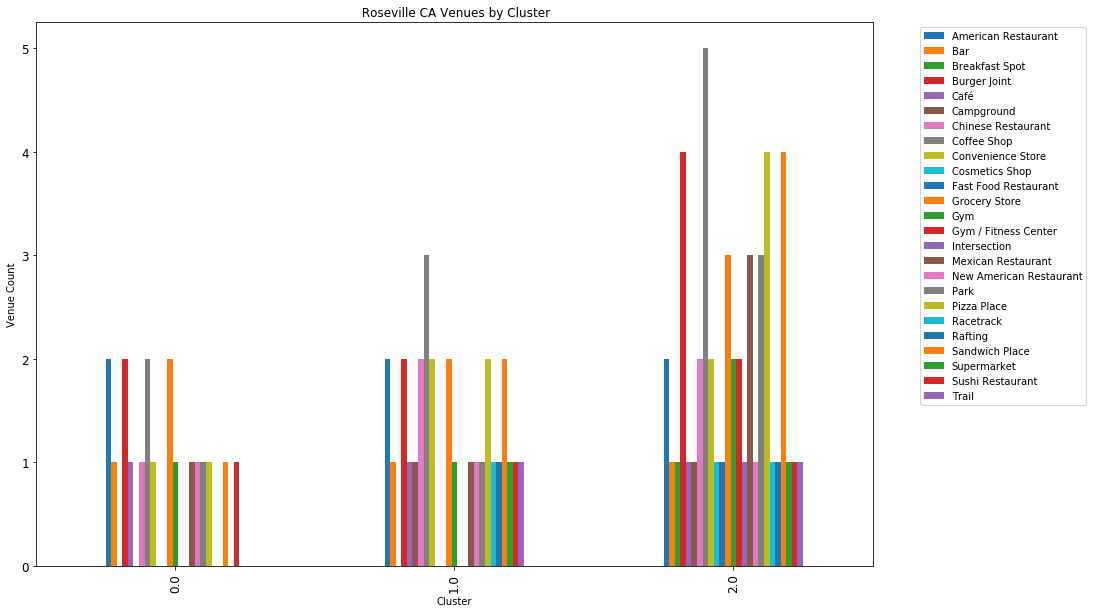

In [43]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

chart_final[ chart_final.columns[0:]].plot(kind='bar', title =" Roseville CA Venues by Cluster", figsize=(15, 10), legend=True, fontsize=12)
plt.legend(loc =2, bbox_to_anchor=(1.05, 1))
plt.xlabel('Cluster')
plt.ylabel('Venue Count')

In [44]:
#AZ chart venues
venue_chart = pd.DataFrame()
for v in range(kclusters): 
 AZvenues_lst = pd.DataFrame(AZvenues_lst)
 get_chartvenues = Chandler_merged.loc[Chandler_merged['Cluster Labels'] == v , Chandler_merged.columns[[1] + list(range(5, Chandler_merged.shape[1]))]]
 get_chartvenues.drop(columns=['mi.','Cluster Labels'], inplace = True)
 for z in range(len( get_chartvenues.index)):
  lst_chartvenues = pd.DataFrame( get_chartvenues.iloc[z].unique())
  lst_chartvenues.columns = {"venue"}
  get_chartvenuesct = lst_chartvenues.groupby('venue').venue.count()

  for j in range(0,len(get_chartvenuesct.index)):
   for w in range(1,len( AZvenues_lst.index)):
    if get_chartvenuesct.index[j] == AZvenues_lst.index[w]:
      AZvenues_lst['count'][w] = AZvenues_lst['count'][w] + get_chartvenuesct[j]
    
 
 venues_list = pd.DataFrame(AZvenues_lst.transpose())  
 venues_list['cluster'] = v
 venue_chart = venue_chart.append(venues_list.loc['count'], ignore_index=True)

In [45]:
chart_final = venue_chart.loc[:, (venue_chart != 0).any(axis=0)]
chart_final.set_index('cluster', inplace = True)

Text(0, 0.5, 'Venue Count')

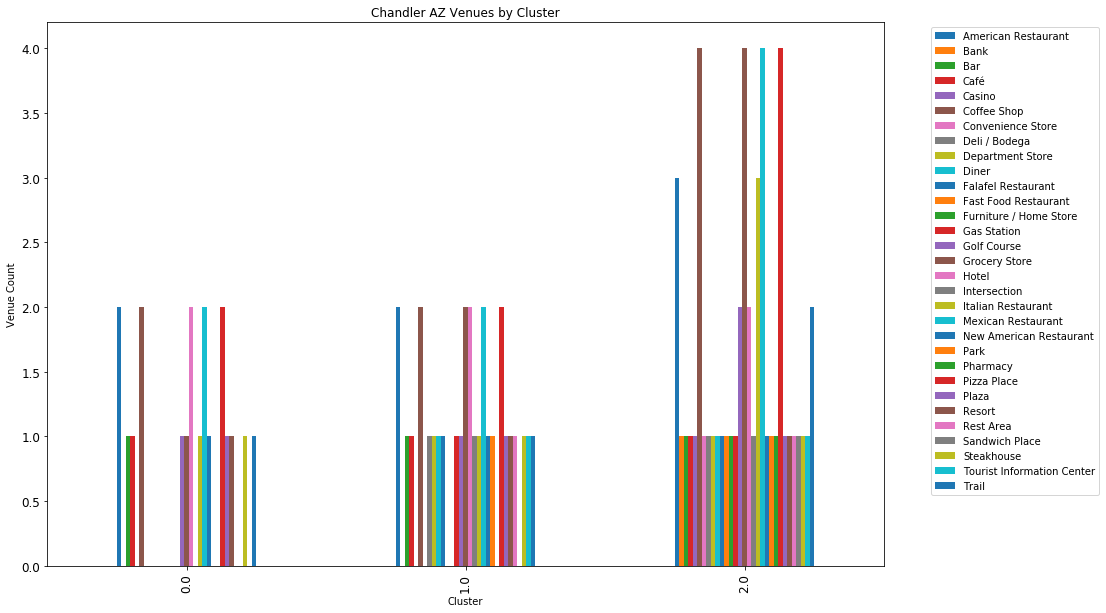

In [46]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

chart_final[ chart_final.columns[0:]].plot(kind='bar', title ="Chandler AZ Venues by Cluster", figsize=(15, 10), legend=True, fontsize=12)
plt.legend(loc =2, bbox_to_anchor=(1.05, 1))
plt.xlabel('Cluster')
plt.ylabel('Venue Count')

Examine Clusters

In [47]:
#Cluster 1
print('Roseville')
print(Roseville_merged.loc[Roseville_merged['Cluster Labels'] == 0, Roseville_merged.columns[[1] + list(range(5, Roseville_merged.shape[1]))]])
print('Chandler')
Chandler_merged.loc[Chandler_merged['Cluster Labels'] == 0, Chandler_merged.columns[[1] + list(range(5, Chandler_merged.shape[1]))]]

Roseville
     mi.  Cluster Labels 1th Most Common Venue 2th Most Common Venue  \
0  10.47               0           Coffee Shop           Pizza Place   
3  11.71               0           Coffee Shop      Sushi Restaurant   

  3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0   American Restaurant          Burger Joint                   Bar   
3         Grocery Store          Burger Joint                   Gym   

  6th Most Common Venue    7th Most Common Venue 8th Most Common Venue  \
0        Sandwich Place       Chinese Restaurant         Grocery Store   
3   American Restaurant  New American Restaurant                  Park   

  9th Most Common Venue 10th Most Common Venue  
0         Deli / Bodega      Convenience Store  
3                  Café     Mexican Restaurant  
Chandler


,mi.,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,12.95,0,Coffee Shop,Pizza Place,American Restaurant,Hotel,Mexican Restaurant,New American Restaurant,Bar,Italian Restaurant,Café,Plaza
3,17.25,0,Hotel,American Restaurant,Pizza Place,Mexican Restaurant,Trail,Coffee Shop,Grocery Store,Golf Course,Resort,Steakhouse


In [39]:
#cluster 2
print('Roseville')
print(Roseville_merged.loc[Roseville_merged['Cluster Labels'] == 1, Roseville_merged.columns[[1] + list(range(5, Roseville_merged.shape[1]))]])
print('Chandler')
Chandler_merged.loc[Chandler_merged['Cluster Labels'] == 1, Chandler_merged.columns[[1] + list(range(5, Chandler_merged.shape[1]))]]

Roseville
     mi.  Cluster Labels 1th Most Common Venue 2th Most Common Venue  \
4  12.13               1     Convenience Store               Rafting   

  3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
4        Sandwich Place                 Trail             Racetrack   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
4           Supermarket           Pizza Place           Coffee Shop   

  9th Most Common Venue 10th Most Common Venue  
4    Chinese Restaurant             Campground  
Chandler


,mi.,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,15.56,1,Rest Area,Grocery Store,Tourist Information Center,Gas Station,Intersection,Park,Falafel Restaurant,Deli / Bodega,Department Store,Diner


In [ ]:
#cluster 3
print('Roseville')
print(Roseville_merged.loc[Roseville_merged['Cluster Labels'] == 2, Roseville_merged.columns[[1] + list(range(5, Roseville_merged.shape[1]))]])
print('Chandler')
Chandler_merged.loc[Chandler_merged['Cluster Labels'] == 2, Chandler_merged.columns[[1] + list(range(5, Chandler_merged.shape[1]))]]